In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from goexplore import *

In [78]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]
with open('atari_games_57.txt') as f:
    env_ids_ignore = [a.strip() for a in f.readlines()]
[env_id for env_id in env_ids if env_id not in env_ids_ignore]

['Adventure',
 'AirRaid',
 'Atlantis2',
 'Backgammon',
 'BasicMath',
 'Blackjack',
 'Carnival',
 'Casino',
 'Crossbow',
 'Darkchambers',
 'DonkeyKong',
 'Earthworld',
 'ElevatorAction',
 'Entombed',
 'Et',
 'FlagCapture',
 'Frogger',
 'Galaxian',
 'Hangman',
 'HauntedHouse',
 'HumanCannonball',
 'JourneyEscape',
 'Kaboom',
 'KeystoneKapers',
 'KingKong',
 'Klax',
 'Koolaid',
 'LaserGates',
 'LostLuggage',
 'MarioBros',
 'MiniatureGolf',
 'MrDo',
 'Othello',
 'Pacman',
 'Pitfall2',
 'Pooyan',
 'SirLancelot',
 'SpaceWar',
 'Superman',
 'Tetris',
 'TicTacToe3d',
 'Trondead',
 'Turmoil',
 'VideoCheckers',
 'VideoChess',
 'VideoCube',
 'WordZapper']

In [308]:
archive = np.load('data/goexplore/goexplore_Pong_0.npy', allow_pickle=True).item()

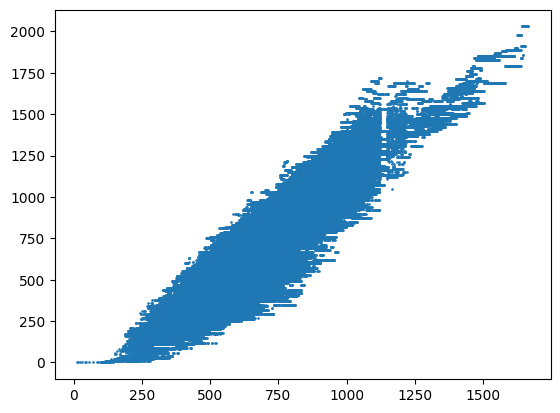

In [309]:
cells = list(archive.values())
rets = [cell.running_ret for cell in cells]
tlens = [len(cell.trajectory) for cell in cells]
plt.scatter(tlens, rets, s=10/np.log(len(rets)))

In [134]:
cells = list(archive.values())
rets = [cell.running_ret for cell in cells]
cells_best = [cell for cell in cells if cell.running_ret==np.max(rets)]
print(f'Max running return found: {np.max(rets)}')
print(f'Total cells: {len(cells)}')
print(f'Best cells: {len(cells_best)}')

Max running return found: 18.0
Total cells: 117
Best cells: 55


In [135]:
cell = cells_best[0]

In [136]:
class GEBuffer(Buffer):
    def __init__(self, env, n_steps, device=None):
        super().__init__(env, n_steps, device=device)
        self.trajs = [None for _ in range(self.env.n_envs)]
        self.traj_lens = np.zeros(self.env.n_envs, dtype=int)
        self.i_locs = np.zeros(self.env.n_envs, dtype=int)
        
    def sample_new_traj(self, ids, sample_traj_fn):
        for id in ids:
            self.trajs[id] = sample_traj_fn()
            self.traj_lens[id] = len(self.trajs[id])
            self.i_locs[id] = 0
        obs, _ = self.env.reset_subenvs(ids)
        self.next_obs[ids] = torch.from_numpy(obs).to(self.device)
    
    def gecollect(self, sample_traj_fn, pbar=None):
        if self.first_collect:
            self.first_collect = False
            _, info = env.reset()
            self.next_obs = info['obs']
            self.sample_new_traj(np.arange(self.env.num_envs), sample_traj_fn)
        for t in range(self.n_steps):
            self.obss[:, t] = self.next_obs
            action = np.array([traj[i_loc] for traj, i_loc in zip(self.trajs, self.i_locs)])
            self.i_locs += 1
            self.acts[:, t] = torch.from_numpy(action)
            _, _, _, _, info = env.step(action)
            self.next_obs = info['obs']
            self.sample_new_traj(np.where(self.i_locs>=self.traj_lens)[0], sample_traj_fn)


In [137]:
len(cell.trajectory)

1765

In [141]:
np.random.seed(0)
torch.manual_seed(0)
env = MyEnvpool('Pong-v5', num_envs=32, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env = ToTensor(env)
gebuff = GEBuffer(env, 128, None)

divs = []
for i in tqdm(range(100)):
    # gebuff.gecollect(sample_traj_fn=lambda : cell.trajectory)
    gebuff.gecollect(sample_traj_fn=lambda : np.random.choice(cells).trajectory)
    div = gebuff.obss.float().var(dim=(0, 1, 2)).mean(dim=(0, 1)).item()
    divs.append(div)

  0%|          | 0/100 [00:00<?, ?it/s]

In [140]:
divs_exploit = divs

In [142]:
divs_explore = divs

In [145]:
np.median(divs_exploit), np.median(divs_explore)

(15.52875804901123, 19.506927490234375)

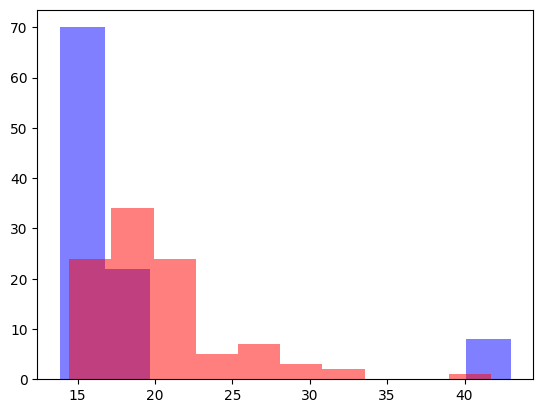

In [144]:
plt.hist(divs_exploit, color=[0, 0, 1, 0.5]);
plt.hist(divs_explore, color=[1, 0, 0, 0.5]);

In [7]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]
with open('atari_games_ignore.txt') as f:
    env_ids_ignore = [a.strip() for a in f.readlines()]
env_ids = [a for a in env_ids if a not in env_ids_ignore]
for env_id in env_ids:
    print(env_id)
    env = MyEnvpool(f'{env_id}-v5', full_action_space=True, use_fire_reset=False, num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1)
    obs, _ = env.reset()
    for i in range(100):
        action = np.random.randint(0, 18, env.num_envs)
        action[action==1] = 0
        obs, _, _, _, _ = env.step(action)
    
    if not obs.var(axis=0).max()>0.:
        print(f'--------{env_id} NEEDS FIRE RESET -------------------')

Adventure
AirRaid
Alien
Amidar
Assault
Asterix
Asteroids
Atlantis
Atlantis2
Backgammon
BankHeist
BasicMath
BattleZone
BeamRider
Berzerk
Blackjack
Bowling
Boxing
Breakout
Carnival
Casino
Centipede
ChopperCommand
CrazyClimber
Crossbow
Darkchambers
Defender
DemonAttack
DonkeyKong
DoubleDunk
Earthworld
ElevatorAction
Enduro
Entombed
Et
FishingDerby
FlagCapture
Freeway
Frostbite
Galaxian
Gopher
Gravitar
Hangman
HauntedHouse
Hero
HumanCannonball
IceHockey
Jamesbond
JourneyEscape
Kaboom
Kangaroo
KeystoneKapers
Klax
Koolaid
Krull
KungFuMaster
LaserGates
MarioBros
MiniatureGolf
MontezumaRevenge
MrDo
MsPacman
NameThisGame
Othello
Pacman
Phoenix
Pitfall
Pitfall2
Pong
Pooyan
PrivateEye
Qbert
Riverraid
RoadRunner
Robotank
Seaquest
SirLancelot
Solaris
SpaceInvaders
SpaceWar
StarGunner
Superman
Surround
Tennis
Tetris
TicTacToe3d
TimePilot
Trondead
Turmoil
Tutankham
UpNDown
Venture
VideoCheckers
VideoChess
VideoCube
VideoPinball
WizardOfWor
WordZapper
YarsRevenge
Zaxxon


In [155]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]

In [ ]:
for env_id in env_ids:
    try:
        archive = np.load(f'data/goexplore/goexplore_{env_id}_0.npy', allow_pickle=True).item()
    except:
        pass

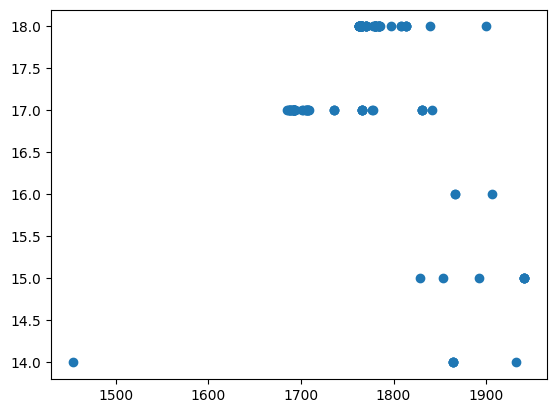

In [85]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]

In [86]:
archives = {}

In [87]:
for env_id in tqdm(env_ids):
    for seed in range(1, 10):
        try:
            archive = np.load(f'data/goexplore/goexplore_{env_id}_{seed}.npy', allow_pickle=True).item()
            if env_id not in archives:
                archives[env_id] = {}
            archives[env_id][seed] = archive
        except:
            archive = None
        
        
        

  0%|          | 0/104 [00:00<?, ?it/s]

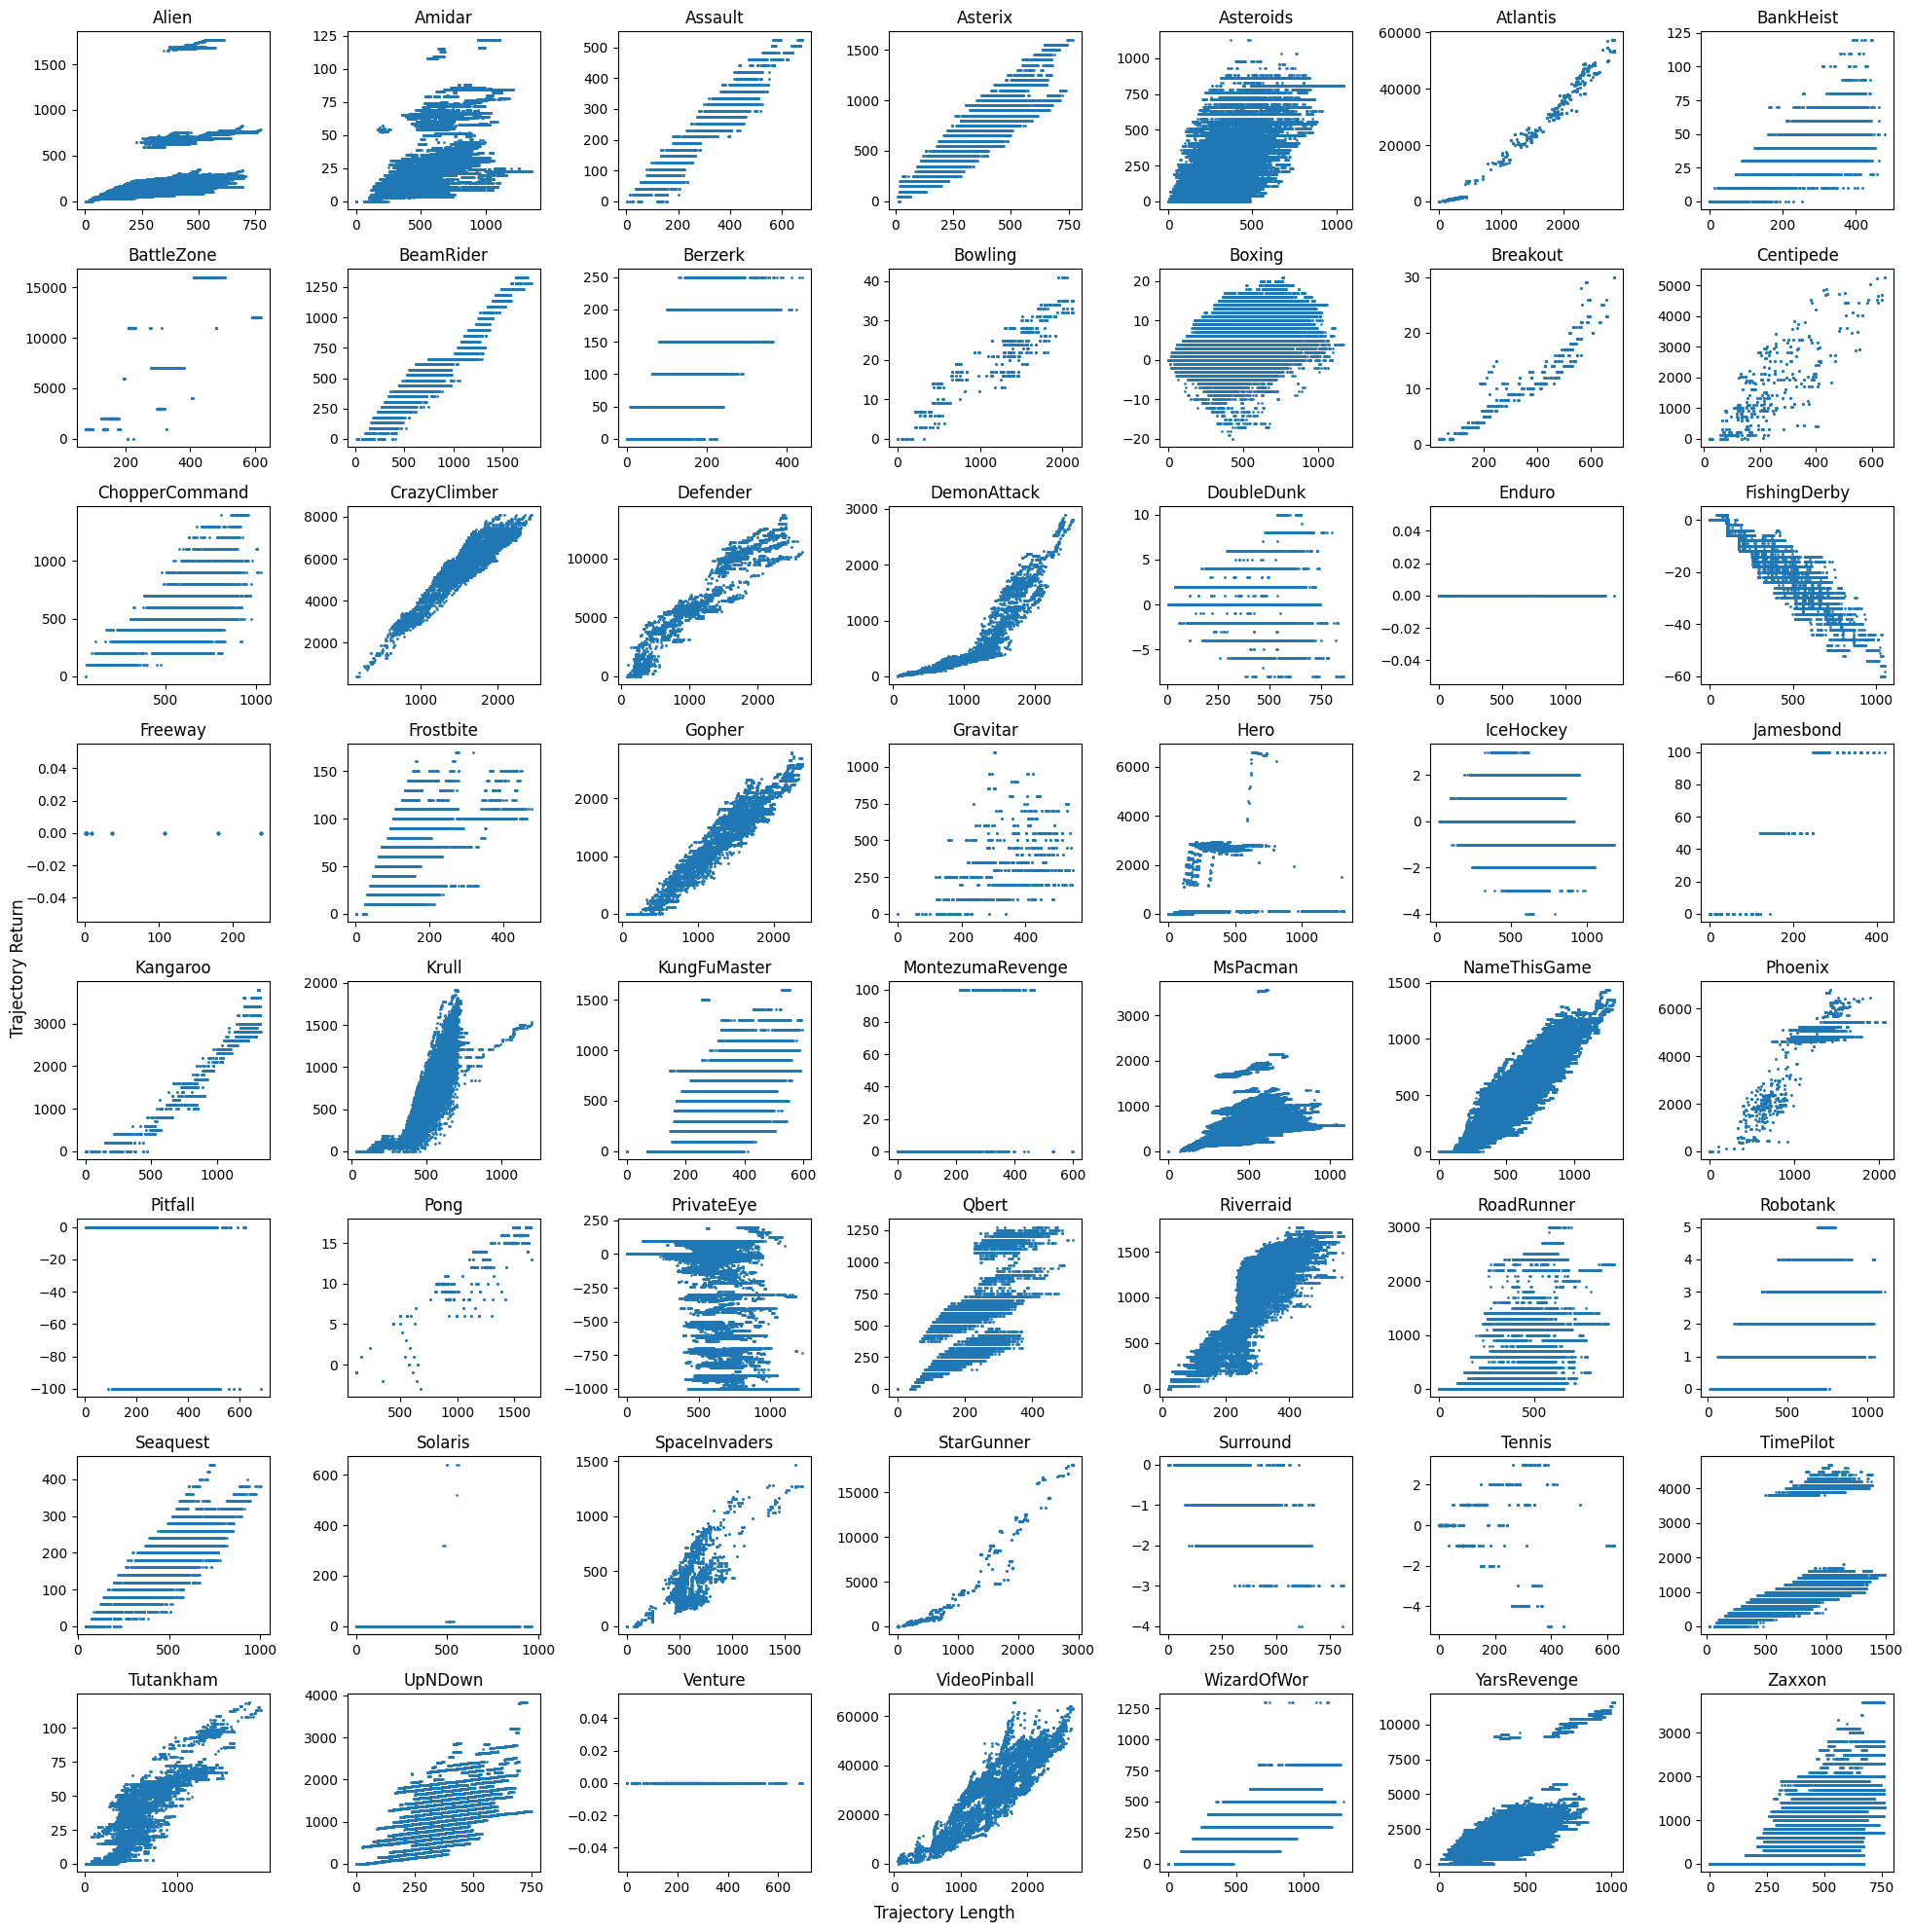

In [88]:
fig = plt.figure(figsize=(20, 20))
for i, env_id in enumerate(archives):
    plt.subplot(8, 7, i+1)
    cells = []
    for seed in archives[env_id]:
        archive = archives[env_id][seed]
        cells.extend(list(archive.values()))
    rets = [cell.running_ret for cell in cells]
    tlens = [len(cell.trajectory) for cell in cells]
    plt.scatter(tlens, rets, s=10/np.log(len(rets)))
    plt.title(env_id)
fig.supxlabel("Trajectory Length")
fig.supylabel("Trajectory Return")
# plt.suptitle("Trajectory Return vs Trajectory Length")
plt.tight_layout()
plt.show()


In [89]:
len(archives[env_id])

9

In [180]:
class GEBuffer(Buffer):
    def __init__(self, env, n_steps, sample_traj_fn, device=None):
        super().__init__(env, n_steps, device=device)
        self.trajs = [None for _ in range(self.env.n_envs)]
        self.traj_lens = np.zeros(self.env.n_envs, dtype=int)
        self.i_locs = np.zeros(self.env.n_envs, dtype=int)
        self.sample_traj_fn = sample_traj_fn
        
    def sample_new_traj(self, ids):
        for id in ids:
            self.trajs[id] = self.sample_traj_fn()
            self.traj_lens[id] = len(self.trajs[id])
            self.i_locs[id] = 0
        obs, _ = self.env.reset_subenvs(ids)
        self.next_obs[ids] = torch.from_numpy(obs).to(self.device)
    
    def gecollect(self, pbar=None):
        if self.first_collect:
            self.first_collect = False
            _, info = env.reset()
            self.next_obs = info['obs']
            self.sample_new_traj(np.arange(self.env.num_envs))
        for t in range(self.n_steps):
            self.obss[:, t] = self.next_obs
            action = np.array([traj[i_loc] for traj, i_loc in zip(self.trajs, self.i_locs)])
            self.i_locs += 1
            self.acts[:, t] = torch.from_numpy(action)
            _, _, _, _, info = env.step(action)
            self.next_obs = info['obs']
            self.sample_new_traj(np.where(self.i_locs>=self.traj_lens)[0])

In [171]:
cells = list(archives['MontezumaRevenge'][6].values())
rets = [cell.running_ret for cell in cells]
tlens = [len(cell.trajectory) for cell in cells]
best_cell = [cell for cell in cells if cell.running_ret==np.max(rets)][0]

In [172]:
device='cuda:0'

In [173]:
np.random.seed(0)
torch.manual_seed(0)
env = MyEnvpool('MontezumaRevenge-v5', num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env = ToTensor(env, device=device)
gebuff = GEBuffer(env, 1024, sample_traj_fn=lambda : best_cell.trajectory, device=device)
# gebuff = GEBuffer(env, 1024, sample_traj_fn=lambda : np.random.choice(cells).trajectory, device=device)


gebuff.gecollect()

In [177]:
len(best_cell.trajectory)

303

In [174]:
gebuff.obss.shape

torch.Size([8, 1024, 1, 84, 84])

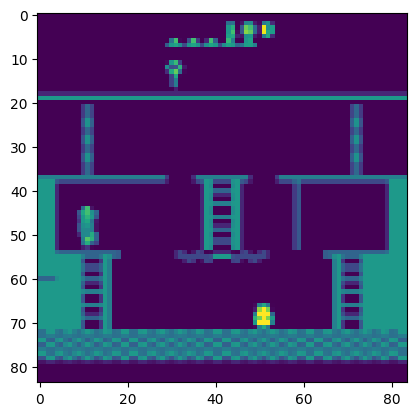

In [179]:
plt.imshow(gebuff.obss[0, 302, 0].detach().cpu().numpy())

In [209]:
def sample_traj(archive_list, sampling='uniform'):
    archive = np.random.choice(archive_list)
    cells = list(archive.values())
    rets = [cell.running_ret for cell in cells]
    # tlens = [len(cell.trajectory) for cell in cells]
    ret_best = np.max(rets)
    cells_best = [cell for cell in cells if cell.running_ret==ret_best]
    if sampling=='uniform':
        return np.random.choice(cells).trajectory
    elif sampling=='best_n':
        return np.random.choice(cells_best).trajectory
    elif sampling=='best_1':
        return cells_best[-1].trajectory

In [210]:
mbuffer = MultiBuffer()
for env_id in tqdm(archives):
    env = MyEnvpool(f'{env_id}-v5', num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False, full_action_space=True)
    env = ToTensor(env, device=device)
    gebuff = GEBuffer(env, 128, sample_traj_fn=partial(sample_traj, archive_list=list(archives[env_id].values()), sampling='uniform'), device=device)
    mbuffer.buffers.append(gebuff)


  0%|          | 0/56 [00:00<?, ?it/s]

In [211]:
for buf in tqdm(mbuffer.buffers):
    buf.gecollect()

  0%|          | 0/56 [00:00<?, ?it/s]

In [216]:
print('hello')
batch = mbuffer.generate_batch(56*8, 4)
print('done')

hello
obs
done
logits
act
val
rew
adv
ret
ram
done


[autoreload of buffers failed: Traceback (most recent call last):
  File "/data/vision/phillipi/akumar01/miniconda3/envs/egb/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/data/vision/phillipi/akumar01/miniconda3/envs/egb/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/data/vision/phillipi/akumar01/miniconda3/envs/egb/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/data/vision/phillipi/akumar01/miniconda3/envs/egb/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/data/vision/phillipi/akumar01/miniconda3/envs/egb/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


In [215]:
batch['obss'].shape

KeyError: 'obss'

In [170]:
env_id = 'MontezumaRevenge'
for seed in archives[env_id]:
    archive = archives[env_id][seed]
    print(env_id, seed)
    print(f'n_cells: {len(archive)}')
    cells = list(archive.values())
    rets = [cell.running_ret for cell in cells]
    tlens = [len(cell.trajectory) for cell in cells]
    print(f'longest traj: {max(tlens)}')
    print(f'best traj: {max(rets)}')

    print()

MontezumaRevenge 1
n_cells: 11
longest traj: 15
best traj: 0.0

MontezumaRevenge 2
n_cells: 660
longest traj: 381
best traj: 0.0

MontezumaRevenge 3
n_cells: 708
longest traj: 327
best traj: 0.0

MontezumaRevenge 4
n_cells: 798
longest traj: 599
best traj: 100.0

MontezumaRevenge 5
n_cells: 11
longest traj: 15
best traj: 0.0

MontezumaRevenge 6
n_cells: 835
longest traj: 467
best traj: 100.0

MontezumaRevenge 7
n_cells: 787
longest traj: 429
best traj: 100.0

MontezumaRevenge 8
n_cells: 11
longest traj: 15
best traj: 0.0

MontezumaRevenge 9
n_cells: 664
longest traj: 314
best traj: 0.0

